# Sentiment Analysis with DistilBERT Transfer Learning

This notebook fine-tunes DistilBERT on Yelp reviews for 3-class sentiment classification:
- **Negative**: 1-2 stars
- **Neutral**: 3 stars  
- **Positive**: 4-5 stars

In [5]:
# Cell 1: Imports and Setup
import torch
import numpy as np
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import json
from model.session_factory import get_db_session
from model.review_repository import ReviewRepository

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"gpu: {torch.cuda.get_device_name(0)}")
else:
    print("Using cpu")

Using device: cuda
gpu: NVIDIA GeForce RTX 3060


In [6]:
# Cell 2: Configuration Parameters
CONFIG = {
    # https://huggingface.co/distilbert/distilbert-base-uncased
    'model_name': 'distilbert-base-uncased',
    'max_length': 512,  # lungime maxima a propozitiei
    'batch_size': 16,   # marime batch
    'num_epochs': 3,    # numar epoci
    'learning_rate': 2e-5, # rata invatare
    'warmup_steps': 500, 
    'weight_decay': 0.01,
    'num_labels': 3,  # negative, neutral, positive
    'train_split': 0.8, 
    'val_split': 0.2,
    'save_dir': 'models',
    'model_save_name': 'distilbert_sentiment_classifier',
    'early_stopping_patience': 2
}

# Label mapping
LABEL_MAP = {
    'negative': 0,  # 1-2 stars
    'neutral': 1,   # 3 stars
    'positive': 2   # 4-5 stars
}
LABEL_NAMES = ['negative', 'neutral', 'positive']
os.makedirs(CONFIG['save_dir'], exist_ok=True)


In [8]:
print("Loading reviews from database...")

session_gen = get_db_session()
session = next(session_gen)

try:
    review_repository = ReviewRepository(session=session)
    
    all_reviews = []
    batch_size = 1000
    offset = 0
    
    while True:
        reviews = review_repository.get_all(limit=batch_size, offset=offset)
        if not reviews:
            break
        all_reviews.extend(reviews)
        offset += batch_size
        print(f"Loaded {len(all_reviews)} reviews...", end='\r')
    
    print(f"\nTotal reviews loaded: {len(all_reviews)}")
    
    if len(all_reviews) == 0:
        raise ValueError(
            "No reviews found in database. Please run load_dataset.py first to populate the database."
        )
    
    # Convert to DataFrame for easier manipulation
    data = []
    for review in all_reviews:
        # Map stars to sentiment labels
        if review.stars <= 2:
            label = 0  # negative
        elif review.stars == 3:
            label = 1  # neutral
        else:  # 4-5 stars
            label = 2  # positive
        
        data.append({
            'text': review.text,
            'stars': review.stars,
            'label': label,
            'review_id': review.review_id
        })
    
    df = pd.DataFrame(data)
    

    for label, name in enumerate(LABEL_NAMES):
        count = len(df[df['label'] == label])
        print(f" {count} review-uri cu label {name}:  ")
    
    # Show sample reviews
    print("\nSample reviews:")
    print(df.head())
finally:
    # Properly close the session by triggering the generator's finally block
    try:
        next(session_gen)
    except StopIteration:
        pass

Loading reviews from database...
Loaded 60000 reviews...
Total reviews loaded: 60000
 20000 review-uri cu label negative:  
 20000 review-uri cu label neutral:  
 20000 review-uri cu label positive:  

Sample reviews:
                                                text  stars  label  \
0  If you decide to eat here, just be aware it is...    3.0      1   
1  I've taken a lot of spin classes over the year...    5.0      2   
2  Family diner. Had the buffet. Eclectic assortm...    3.0      1   
3  Wow!  Yummy, different,  delicious.   Our favo...    5.0      2   
4  Cute interior and owner (?) gave us tour of up...    4.0      2   

                review_id  
0  KU_O5udG6zpxOg-VcAEodg  
1  BiTunyQ73aT9WBnpR9DZGw  
2  saUsX_uimxRlCVr67Z4Jig  
3  AqPFMleE6RsU23_auESxiA  
4  Sx8TMOWLNuJBWer-0pcmoA  


In [ ]:
class SentimentDataset(Dataset):
    """Custom Dataset for sentiment analysis."""
    
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }



In [11]:
# Cell 5: Initialize Tokenizer and Create Datasets
print("Loading tokenizer...")
tokenizer = DistilBertTokenizer.from_pretrained(CONFIG['model_name'])
print(f"Tokenizer loaded: {CONFIG['model_name']}")

# Create full dataset
print("\nCreating PyTorch datasets...")
full_dataset = SentimentDataset(
    texts=df['text'].values,
    labels=df['label'].values,
    tokenizer=tokenizer,
    max_length=CONFIG['max_length']
)

# Split into train and validation (80/20)
train_size = int(CONFIG['train_split'] * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=0  
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=0
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")



Loading tokenizer...
Tokenizer loaded: distilbert-base-uncased

Creating PyTorch datasets...
Training samples: 48000
Validation samples: 12000
Training batches: 3000
Validation batches: 750


In [12]:
# Cell 6: Initialize Model and Optimizer
print("Loading DistilBERT model...")
model = DistilBertForSequenceClassification.from_pretrained(
    CONFIG['model_name'],
    num_labels=CONFIG['num_labels']
)
model.to(device)
print(f"Model loaded and moved to {device}")

# Optimizer: AdamW with weight decay
optimizer = AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

total_steps = len(train_loader) * CONFIG['num_epochs']
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=CONFIG['warmup_steps'],
    num_training_steps=total_steps
)


print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {CONFIG['warmup_steps']}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Loading DistilBERT model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and moved to cuda
Total training steps: 9000
Warmup steps: 500
Model parameters: 66,955,779
Trainable parameters: 66,955,779


In [13]:
def train_epoch(model, data_loader, optimizer, scheduler, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    progress_bar = tqdm(data_loader, desc="Training")
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return avg_loss, accuracy


def evaluate(model, data_loader, device):
    """Evaluate the model."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Evaluating")
        
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1, all_preds, all_labels

print("Training and evaluation functions defined successfully")

Training and evaluation functions defined successfully


In [14]:
#training Loop
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': []
}

best_val_f1 = 0
patience_counter = 0

print("Starting training...\n")
print("="*60)
start_time = datetime.now()

for epoch in range(CONFIG['num_epochs']):
    print(f"\nEpoch {epoch + 1}/{CONFIG['num_epochs']}")
    print("-" * 60)
    
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, scheduler, device
    )
    
    # Evaluate
    val_loss, val_acc, val_f1, val_preds, val_labels = evaluate(
        model, val_loader, device
    )
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        
        # Save model checkpoint
        checkpoint_path = os.path.join(CONFIG['save_dir'], CONFIG['model_save_name'])
        os.makedirs(checkpoint_path, exist_ok=True)
        
        model.save_pretrained(checkpoint_path)
        tokenizer.save_pretrained(checkpoint_path)
        
        # Save config
        config_path = os.path.join(checkpoint_path, 'training_config.json')
        with open(config_path, 'w') as f:
            json.dump({
                **CONFIG,
                'label_map': LABEL_MAP,
                'label_names': LABEL_NAMES,
                'best_val_f1': float(best_val_f1),
                'trained_on': str(datetime.now())
            }, f, indent=2)
        
        print(f"✓ Saved best model (F1: {val_f1:.4f})")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{CONFIG['early_stopping_patience']}")
    
    # Early stopping
    if patience_counter >= CONFIG['early_stopping_patience']:
        print(f"\nEarly stopping triggered after {epoch + 1} epochs")
        break

end_time = datetime.now()
training_time = end_time - start_time
print("\n" + "="*60)
print(f"Training completed in {training_time}")
print(f"Best validation F1: {best_val_f1:.4f}")
print("="*60)

Starting training...


Epoch 1/3
------------------------------------------------------------


Training:   0%|          | 5/3000 [00:04<47:44,  1.05it/s, loss=1.09]  


KeyboardInterrupt: 

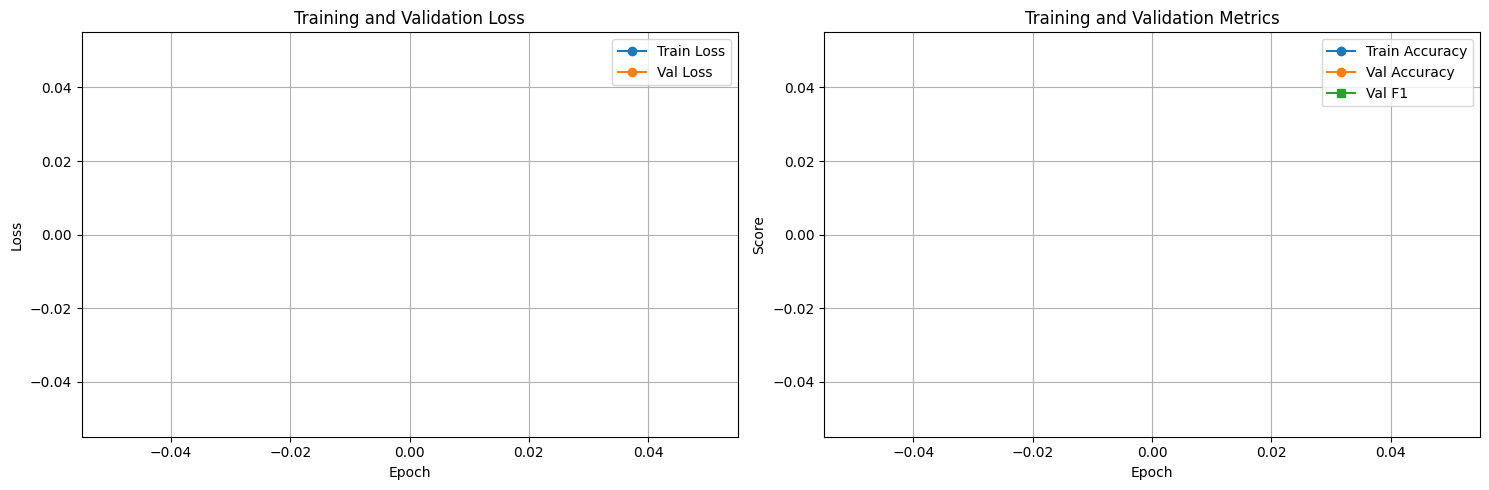

Training history plot saved to models\training_history.png


In [15]:
# plot history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Val Accuracy', marker='o')
axes[1].plot(history['val_f1'], label='Val F1', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Training and Validation Metrics')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['save_dir'], 'training_history.png'), dpi=150)
plt.show()

print(f"Training history plot saved to {os.path.join(CONFIG['save_dir'], 'training_history.png')}")

Loading best model for final evaluation...



Evaluating: 100%|██████████| 750/750 [02:01<00:00,  6.15it/s]



FINAL VALIDATION METRICS
Accuracy: 0.8159
F1 Score (weighted): 0.8168

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

    negative     0.8397    0.8570    0.8483      3999
     neutral     0.7226    0.7505    0.7363      4008
    positive     0.8935    0.8405    0.8662      3993

    accuracy                         0.8159     12000
   macro avg     0.8186    0.8160    0.8169     12000
weighted avg     0.8185    0.8159    0.8168     12000



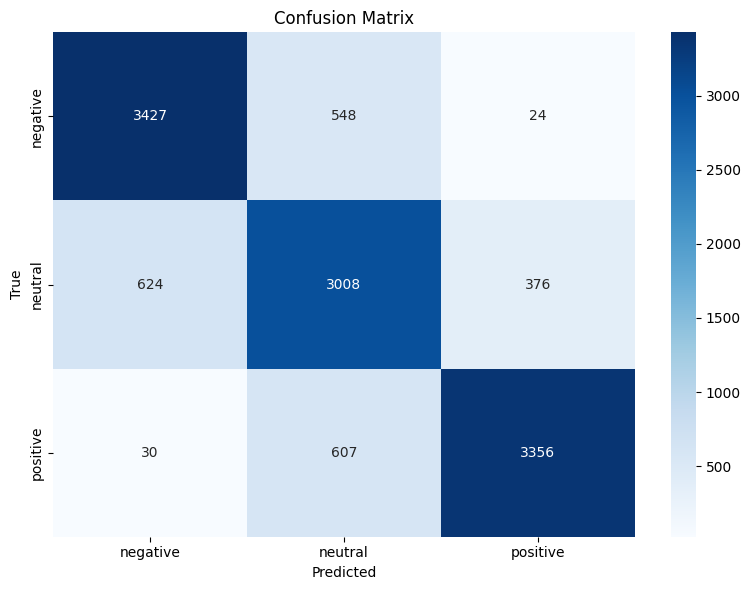


Confusion matrix saved to models\confusion_matrix.png

------------------------------------------------------------
Per-class Accuracy:
------------------------------------------------------------
  negative: 0.8570 (3999 samples)
  neutral: 0.7505 (4008 samples)
  positive: 0.8405 (3993 samples)


In [16]:
# Cell 10: Detailed Evaluation Metrics
print("Loading best model for final evaluation...\n")
model = DistilBertForSequenceClassification.from_pretrained(
    os.path.join(CONFIG['save_dir'], CONFIG['model_save_name'])
)
model.to(device)

# Final evaluation
val_loss, val_acc, val_f1, val_preds, val_labels = evaluate(
    model, val_loader, device
)

print("\n" + "="*60)
print("FINAL VALIDATION METRICS")
print("="*60)
print(f"Accuracy: {val_acc:.4f}")
print(f"F1 Score (weighted): {val_f1:.4f}")

# Classification report
print("\n" + "-"*60)
print("Classification Report:")
print("-"*60)
print(classification_report(
    val_labels,
    val_preds,
    target_names=LABEL_NAMES,
    digits=4
))

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=LABEL_NAMES,
    yticklabels=LABEL_NAMES
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['save_dir'], 'confusion_matrix.png'), dpi=150)
plt.show()

print(f"\nConfusion matrix saved to {os.path.join(CONFIG['save_dir'], 'confusion_matrix.png')}")

# Per-class accuracy
print("\n" + "-"*60)
print("Per-class Accuracy:")
print("-"*60)
for i, label_name in enumerate(LABEL_NAMES):
    mask = np.array(val_labels) == i
    if mask.sum() > 0:
        class_acc = accuracy_score(
            np.array(val_labels)[mask],
            np.array(val_preds)[mask]
        )
        print(f"  {label_name}: {class_acc:.4f} ({mask.sum()} samples)")
print("="*60)

In [17]:
# Cell 11: Test Predictions on Sample Reviews
def predict_sentiment(text, model, tokenizer, device, max_length=512):
    """Predict sentiment for a single text."""
    model.eval()
    
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        pred = torch.argmax(probs, dim=1)
    
    return LABEL_NAMES[pred.item()], probs.cpu().numpy()[0]

# Test samples
test_samples = [
    "This place is absolutely amazing! Best food I've ever had! The service was exceptional.",
    "Terrible service and cold food. Never coming back. Waste of money.",
    "It was okay. Nothing special but not bad either. Average experience.",
    "Great atmosphere and friendly staff. Highly recommend!",
    "Worst restaurant ever. The food was disgusting and overpriced."
]

print("="*60)
print("SAMPLE PREDICTIONS")
print("="*60)

for i, text in enumerate(test_samples, 1):
    sentiment, probs = predict_sentiment(text, model, tokenizer, device)
    print(f"\n{i}. Text: {text}")
    print(f"   Predicted: {sentiment.upper()}")
    print(f"   Probabilities: negative={probs[0]:.3f}, neutral={probs[1]:.3f}, positive={probs[2]:.3f}")

print("\n" + "="*60)

SAMPLE PREDICTIONS

1. Text: This place is absolutely amazing! Best food I've ever had! The service was exceptional.
   Predicted: POSITIVE
   Probabilities: negative=0.001, neutral=0.002, positive=0.997

2. Text: Terrible service and cold food. Never coming back. Waste of money.
   Predicted: NEGATIVE
   Probabilities: negative=0.996, neutral=0.004, positive=0.001

3. Text: It was okay. Nothing special but not bad either. Average experience.
   Predicted: NEUTRAL
   Probabilities: negative=0.036, neutral=0.954, positive=0.010

4. Text: Great atmosphere and friendly staff. Highly recommend!
   Predicted: POSITIVE
   Probabilities: negative=0.001, neutral=0.003, positive=0.996

5. Text: Worst restaurant ever. The food was disgusting and overpriced.
   Predicted: NEGATIVE
   Probabilities: negative=0.996, neutral=0.003, positive=0.001

